In [37]:
from pathlib import Path
import os

from astropy.nddata import CCDData
from astropy.visualization import hist
from astropy.stats import mad_std

import ccdproc as ccdp
import matplotlib.pyplot as plt
import numpy as np
import sys
from astropy import units as u


sys.path.append("/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline")
import fpnfix
from aperturePhot import showimage as show_image

In [38]:
path = "/home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/"
day = "20201201"
path_day = os.path.join(path, day)

data_red = Path(path_day, "Reduced_Images")
data_red.mkdir(exist_ok = True)

In [39]:
files = ccdp.ImageFileCollection(path_day)
files.summary['file', 'imagetyp', 'filter', 'exptime', 'naxis1', 'naxis2']

file,imagetyp,filter,exptime,naxis1,naxis2
str20,str11,object,float64,int64,int64
Bias-001.fit,Bias Frame,--,0.0,1024,1024
Bias-002.fit,Bias Frame,--,0.0,1024,1024
Bias-003.fit,Bias Frame,--,0.0,1024,1024
Bias-004.fit,Bias Frame,--,0.0,1024,1024
Bias-005.fit,Bias Frame,--,0.0,1024,1024
Bias-006.fit,Bias Frame,--,0.0,1024,1024
Bias-007.fit,Bias Frame,--,0.0,1024,1024
Bias-008.fit,Bias Frame,--,0.0,1024,1024
Bias-009.fit,Bias Frame,--,0.0,1024,1024


In [40]:
calibrated_biases = files.files_filtered(imagetyp='Bias Frame', include_path=True)

combined_bias = ccdp.combine(calibrated_biases,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit = "adu")

combined_bias.meta['combined'] = True

combined_bias.write(os.path.join(data_red / 'combined_bias.fit'), overwrite = True)

In [41]:
calibrated_darks = files.files_filtered(imagetyp='Dark Frame', include_path=True)
reduced_darks= []
exptime= []

for frame in calibrated_darks:
    image = ccdp.CCDData.read(frame, unit = 'adu')
    exptime.append(image.header["exposure"])
    reduced_darks.append(ccdp.subtract_bias(image, combined_bias))
    
combined_darks = ccdp.combine(reduced_darks,
                             method='median',
                             sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                             sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std, unit = "adu", scale =1 / np.array(exptime))

combined_darks.header["exposure"] = 1
combined_darks.header['exptime'] = 1

combined_darks.meta['combined'] = True

combined_darks.write(os.path.join(data_red / 'combined_darks.fit'), overwrite = True)

In [42]:
flat_imagetyp = 'Flat Field'

flat_filters = set(h['filter'] for h in files.headers(imagetyp=flat_imagetyp))
flat_filters

{'Bessel B', 'Bessel R', 'Bessel V'}

In [43]:
scale = lambda a: 1/np.median(a)

master_flats = {}

for filt in flat_filters:
    reduced_flats = []
    calibrated_flats = files.files_filtered(imagetyp = flat_imagetyp, filter = filt, include_path=True)
    
    for flat in calibrated_flats:
        image = ccdp.CCDData.read(flat, unit = "adu")
        image = ccdp.subtract_bias(image, combined_bias)
        image = ccdp.subtract_dark(image, combined_darks, scale=True, exposure_unit=u.s, exposure_time = "exptime")
        #image = fpnfix.subtract_fpn(image,combfpn[60],mesh_size=32, verbose = 2)
        reduced_flats.append(image)
    
    combined_flats = ccdp.combine(reduced_flats,
                                 method='median',
                                 sigma_clip=True, sigma_clip_low_thresh=5, sigma_clip_high_thresh=5,
                                 sigma_clip_func=np.ma.median, signma_clip_dev_func=mad_std, unit = "adu", scale = scale
                                )

    master_flats[filt]=combined_flats.copy()

    combined_flats.write(data_red / (filt.replace("","_")+"_combined_flats.fit"), overwrite = True)

784.7473721504211 2.2239
777.0 795.8728012288153


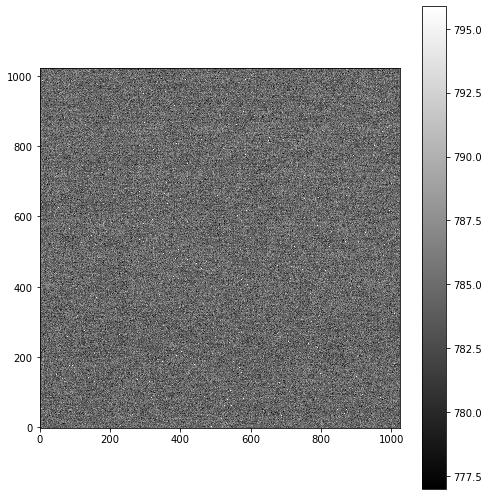

In [44]:
show_image(combined_bias)

0.09507141908009847 0.061775000000000004
-0.10833333333333334 0.4172966743458289


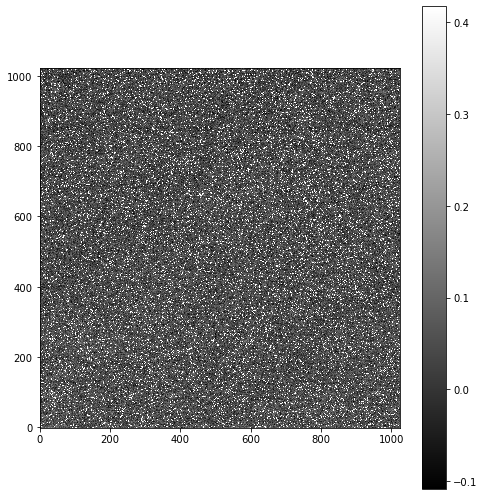

In [45]:
show_image(combined_darks)

1.0000217298068936 0.005894297373305431
0.9693523386957477 1.0219442507744714


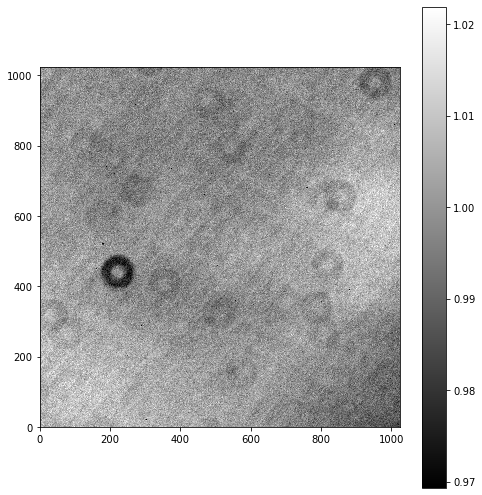

1.002273888980933 0.008646114053297608
0.9672071284261233 1.043739008791559


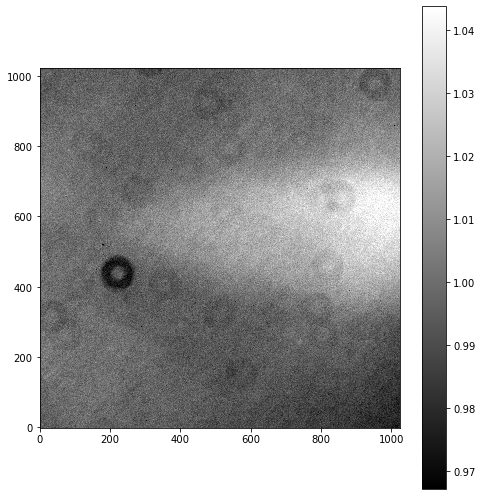

0.9997229182176975 0.005754744153074818
0.9670830828761383 1.015725741753197


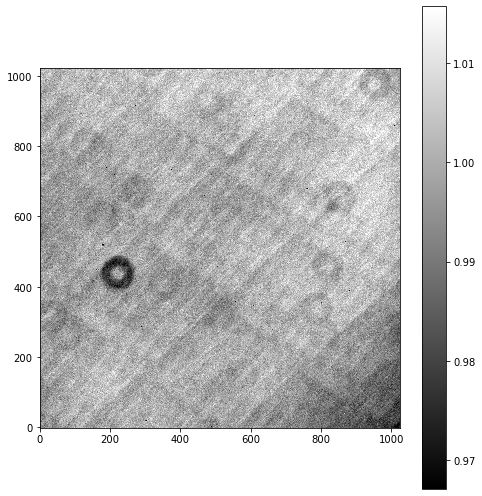

In [46]:
for filt,image in master_flats.items():
    show_image(image)

In [49]:
import ccdproc
images = files.files_filtered(imagetyp="Light Frame", include_path = True)

for image in images:
    var = ccdp.CCDData.read(image, unit = "adu")
    var_filt = var.header["filter"]
    
    corr_filt = master_flats[var_filt]
    
    var = ccdproc.ccd_process(var,
                             master_bias = combined_bias, dark_frame = combined_darks,
                             master_flat = corr_filt, exposure_key="exposure", exposure_unit = u.second,
                             dark_scale = True)
    proc_data = os.path.basename(image)
    var.write(data_red / ("BDF_"+proc_data), overwrite = True)

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
486.3205269582155 17.77391288741776
432.5047097198923 585.2042338222119


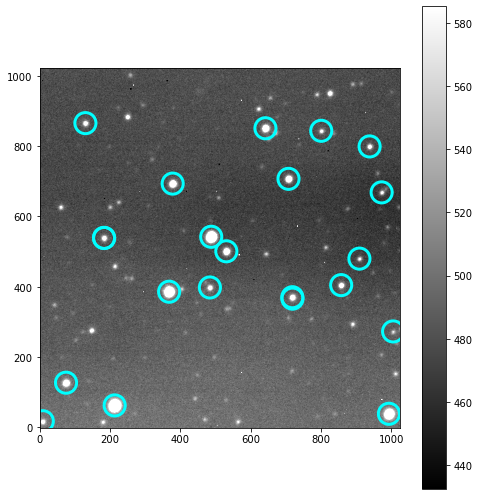

      xcentroid   ycentroid       mag
2    212.780878   62.447137 -3.717838
14   487.482063  542.286439 -3.298640
7    367.722206  385.982881 -3.056124
1    993.045409   38.689808 -3.015400
16   377.826103  693.605548 -1.544343
20   641.728216  851.028270 -1.495633
17   707.431719  707.130429 -1.225769
11   530.502159  500.997686 -1.177929
3     74.461211  127.083550 -0.964363
6    718.240187  370.318545 -0.669443
9    857.178075  404.772760 -0.585019
12   182.681441  538.744948 -0.228706
21   129.543050  865.637197 -0.148841
8    483.732412  398.067268 -0.099700
15   972.347605  668.611869 -0.083453
10   909.102353  480.168460 -0.060819
13   182.607076  539.163781 -0.049080
18   938.152961  799.327713 -0.039740
5    718.682792  366.280887 -0.032306
19   800.499540  843.778081 -0.030944
4   1004.958753  272.944987 -0.001302
0      8.264977   17.535521 -0.000278
Point RA 23 41 57
Point Dec +44 11 17
objcoord <SkyCoord (ICRS): (ra, dec) in deg
    (355.4875, 44.18805556)>
radecstr 355.48

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


Return code: 0 


dxfit [4.16005225e+02 1.60055864e+00 2.75848323e-01]
dyfit [ 4.95648269e+02 -2.75868794e-01  1.59996033e+00]

scalex, scaley: 0.615704689184641 0.6159269708312566
anglex, angley: -9.778580751115454 -9.782878780898528
fracdiffs: 0.0004395351321901965 0.000361019902105814

# Created by grmatch 0.9e0 (fi: 0.9.4)
# Invoked command: /home/idies/workspace/Storage/madisonleblanc/persistent/bin/grmatch -r /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201201/Reduced_Images/BDF_HH_And_0000_001R.gaia.proj -i /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201201/Reduced_Images/BDF_HH_And_0000_001R.stars.csv -o /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201201/Reduced_Images/BDF_HH_And_0000_001R.match.csv --match-points --col-ref 4,5 --col-inp 2,3 --output-transformation /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201201/Reduced_Images/BDF_HH_And_0000

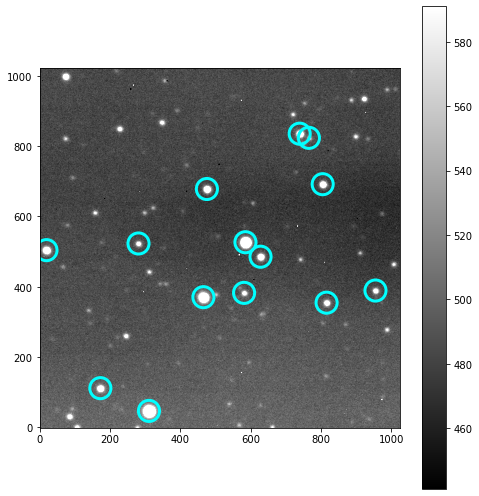

     xcentroid   ycentroid       mag
0   310.392716   46.919408 -3.560625
9   584.859245  526.759396 -3.142576
3   465.274321  370.420847 -2.798222
10  475.234035  678.212996 -1.438415
7    18.822210  504.263286 -1.353358
13  739.145862  835.582034 -1.351823
11  804.577396  691.870567 -1.162334
6   627.814183  485.541209 -1.062332
1   172.089325  111.569437 -0.963004
2   815.701527  354.780435 -0.497686
4   581.003774  382.669820 -0.444750
5   954.866513  389.363447 -0.296109
8   280.585141  523.227165 -0.128616
12  765.388207  823.756294 -0.055040
Point RA 23 41 51
Point Dec +44 11 17
objcoord <SkyCoord (ICRS): (ra, dec) in deg
    (355.4625, 44.18805556)>
radecstr 355.462 44.1881
Search radius = 0.13106342470013851 deg
        ra                dec         phot_g_mean_mag
       deg                deg               mag      
------------------ ------------------ ---------------
355.45682608764184   44.1091497298546        10.34314
355.47999369869643 44.170596761287726       10.365541

INFO:astropy:using the unit adu passed to the FITS reader instead of the unit adu in the FITS file.


Return code: 0 


dxfit [4.10106914e+02 1.60080315e+00 2.75545596e-01]
dyfit [ 4.97868635e+02 -2.75249737e-01  1.59961401e+00]

scalex, scaley: 0.6156328288854611 0.6160963568315097
anglex, angley: -9.766592914384686 -9.763421207304573
fracdiffs: 0.00032475061753010583 0.0007529292206325405

# Created by grmatch 0.9e0 (fi: 0.9.4)
# Invoked command: /home/idies/workspace/Storage/madisonleblanc/persistent/bin/grmatch -r /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201201/Reduced_Images/BDF_HH_And_0100_001R.gaia.proj -i /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201201/Reduced_Images/BDF_HH_And_0100_001R.stars.csv -o /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201201/Reduced_Images/BDF_HH_And_0100_001R.match.csv --match-points --col-ref 4,5 --col-inp 2,3 --output-transformation /home/idies/workspace/Storage/madisonleblanc/persistent/reductions_ASTR4261/20201201/Reduced_Images/BDF_HH_And_0

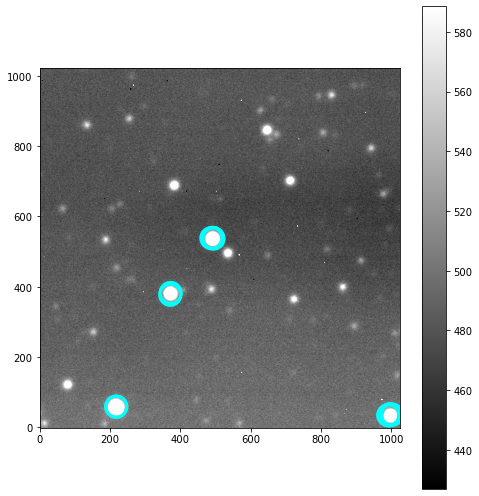

      xcentroid   ycentroid       mag
6    217.168760   59.181421 -1.620863
5    217.306891   58.851171 -1.358053
10   491.692234  538.808841 -1.286366
12   492.176545  539.298511 -1.167067
9    494.075301  537.066054 -0.990082
8    372.069408  382.573908 -0.954996
3    997.562194   37.921395 -0.740345
11   487.898065  538.455197 -0.693715
2    993.909046   35.763298 -0.364404
7    371.015822  377.152124 -0.355798
4   1002.141273   36.048415 -0.276289
0    993.916791   34.387567 -0.116458
1    990.839218   34.761089 -0.038777
Point RA 23 41 57
Point Dec +44 11 17
objcoord <SkyCoord (ICRS): (ra, dec) in deg
    (355.4875, 44.18805556)>
radecstr 355.487 44.1881
Search radius = 0.13106342470013851 deg
        ra                dec         phot_g_mean_mag
       deg                deg               mag      
------------------ ------------------ ---------------
355.45682608764184   44.1091497298546        10.34314
355.47999369869643 44.170596761287726       10.365541
 355.5019035183828 44.

/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:298: RuntimeWarning: divide by zero encountered in double_scalars
  scalex = 1.0/(dxfit[1]/np.cos(anglex))
/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:299: RuntimeWarning: divide by zero encountered in double_scalars
  scaley = 1.0/(dyfit[2]/np.cos(angley))
/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:301: RuntimeWarning: invalid value encountered in double_scalars
  fracanglediff = np.abs((anglex - angley)/anglex)
/home/idies/workspace/Storage/madisonleblanc/persistent/hrpo-pipeline/plateSolve.py:302: RuntimeWarning: invalid value encountered in double_scalars
  fracscalediff = np.abs((scalex-scaley)/scalex)


In [56]:
import plateSolve
pathlist = Path(data_red).glob('BDF_HH_And*R.fit')

for path in pathlist:
    #show_image(Rimage)
    Rimage = ccdp.CCDData.read(path, unit="adu")
    
    check = plateSolve.autoSolve(path,Rimage, verbose = 1)
    if (check == True):
        #print(check)
        print(Rimage.header['JD-HELIO'])
        print("______________________________________________")
        
    else:
        print("!!!!!!!Plate solve did not work for", path)
        print("______________________________________________")
        print(" ")

In [ ]:
plateSolve.manualSolvePlot(V,Vimage)

In [ ]:
gaia_list = [0,1, 3, 9, 12,17,22,24,54]
image_list = [0,1,4,5,8, 11, 13, 15,16]

check = plateSolve.manualSolve(V,Vimage,gaia_list,image_list)
print("Check is True if successful")
print(V,check)


Help on NoneType object:

class NoneType(object)
 |  Methods defined here:
 |  
 |  __bool__(self, /)
 |      self != 0
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  ----------------------------------------------------------------------
 |  Static methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.

